<a href="https://colab.research.google.com/github/Deca97/Food_Images_Classification/blob/main/Food_Images_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ottimizzazione delle prestazioni di una rete neurale per il settore food

**Dettagli del Progetto:** Sviluppo di un modello avanzato di classificazione di immagini di cibo utilizzando tecniche di deep learning. Il progetto si baserà sul dataset Food Classification, arricchito con tecniche di augmentation per migliorare la diversità e la qualità dei dati disponibili.

## INSTALLING REQUIRED LIBRARIES

In [ ]:
# 1) Installa dipendenze
!pip install -q timm albumentations==1.3.1 torchmetrics==0.11.4 einops optuna

## DATASET EXTRACTION

In [ ]:
# 2) Import principali
import os
import random
from pathlib import Path
import shutil
import zipfile
import math

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)




# 3) Configurazione semplice
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE:', DEVICE)

# Percorso dataset
DATA_URL = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip'
WORKDIR = Path('/content/gourmetai_food')
WORKDIR.mkdir(parents=True, exist_ok=True)


# 4) Scarica e estrai dataset
zip_path = WORKDIR / 'dataset_food_classification.zip'
if not zip_path.exists():
    print('Scaricando dataset...')
    !wget -q -O {str(zip_path)} {DATA_URL}
else:
    print('Zip già presente')

extracted_dir = WORKDIR / 'dataset'
if not extracted_dir.exists():
    print('Estraendo...')
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extracted_dir)
else:
    print('Cartella estratta già presente')



# Trova tutte le immagini e labels
image_paths = list(extracted_dir.rglob('*.jpg')) + list(extracted_dir.rglob('*.png')) + list(extracted_dir.rglob('*.jpeg'))
print('Tot immagini trovate:', len(image_paths))

labels = [p.parent.name for p in image_paths]
unique_labels = sorted(list(set(labels)))
num_classes = len(unique_labels)
print('Classi trovate:', num_classes)
label2idx = {l:i for i,l in enumerate(unique_labels)}

DEVICE: cuda
Zip già presente
Cartella estratta già presente
Tot immagini trovate: 14000
Classi trovate: 14


## DATA VISUALIZATION

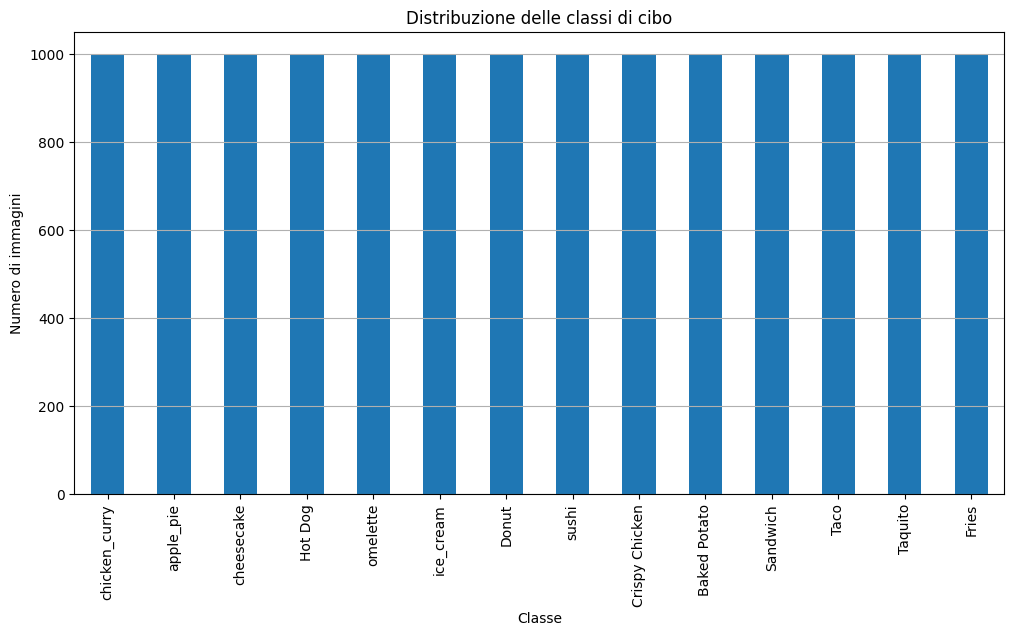

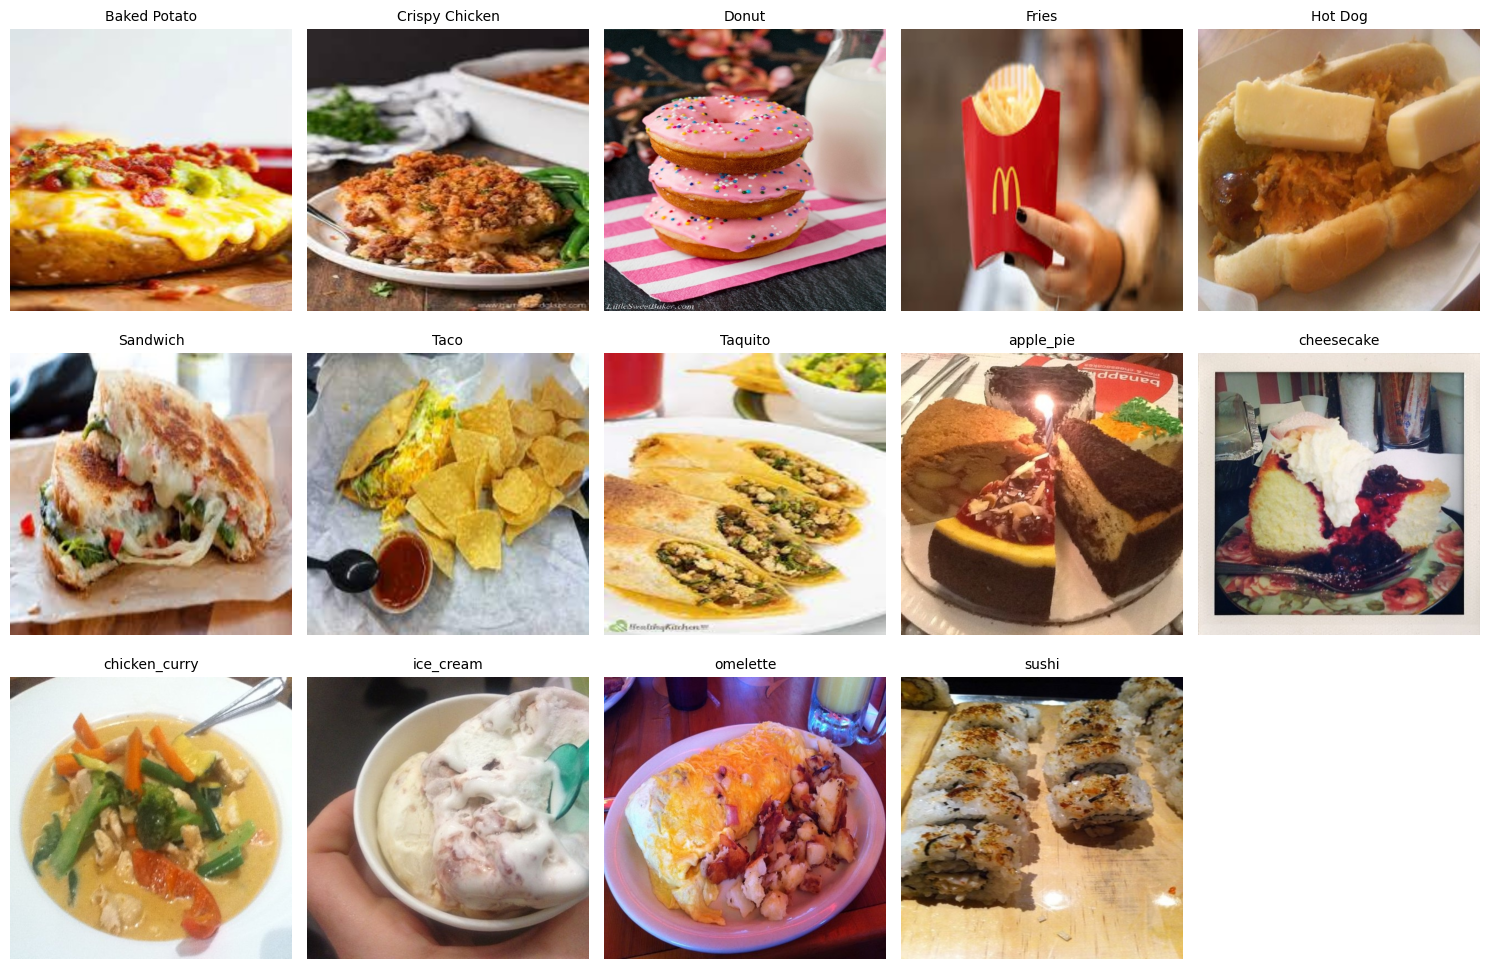

In [ ]:
# 5) Visualizzazione dataset

# Creiamo DataFrame semplice
import pandas as pd
rows = [(str(p), p.parent.name, label2idx[p.parent.name]) for p in image_paths]
df = pd.DataFrame(rows, columns=['path','label_name','label'])

# EDA: Distribuzione classi
plt.figure(figsize=(12,6))
df['label_name'].value_counts().plot(kind='bar')
plt.title('Distribuzione delle classi di cibo')
plt.xlabel('Classe')
plt.ylabel('Numero di immagini')
plt.grid(axis='y')
plt.show()

# Esempio visivo: una immagine per ogni classe
example_df = df.groupby('label_name').first().reset_index()

plt.figure(figsize=(15, 10))
for i, (path, label) in enumerate(zip(example_df['path'], example_df['label_name'])):
    img = Image.open(path).convert('RGB')
    plt.subplot(math.ceil(num_classes / 5), 5, i + 1)  # layout automatico
    plt.imshow(img)
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

Il dataset contiene 14 classi diverse di cibo perfettamente bilanciate.

## DATA AUGMENTATION

Applichiamo diverse tecniche di augmentation per arricchire il dataset, migliorando la variabilità e la qualità dei dati.

Train: 9800 Val: 2100 Test: 2100


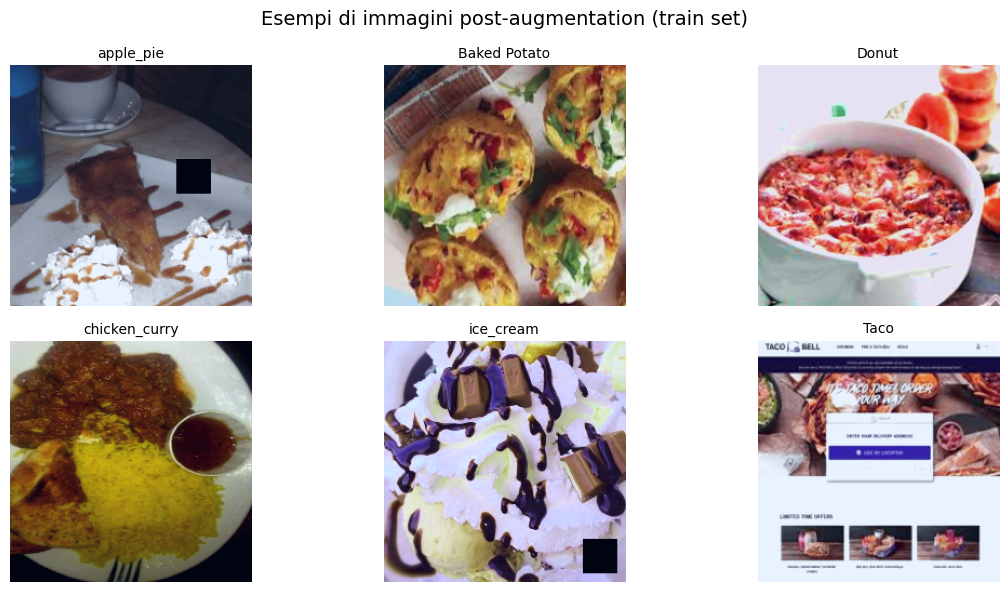

In [ ]:
# 6) Ripartizione train/val/test (stratificata)

from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Stratified split: train 70%, val 15%, test 15%
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)

print('Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

# Mappatura per mostrare i nomi corretti
idx_to_labelname = dict(zip(df['label'], df['label_name']))

# 7) Augmentation (Albumentations)
IMAGE_SIZE = 224

train_transforms = A.Compose([
    A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, scale=(0.7,1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=25, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.4),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.2),
    A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.3),
    A.Normalize(),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# 8) Dataset custom (senza replay)
class FoodDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(row['path']).convert('RGB'))
        label = int(row['label'])

        if self.transforms:
            img = self.transforms(image=img)['image']

        return img, label

# 9) DataLoaders
BATCH_SIZE = 64

train_ds = FoodDataset(train_df, transforms=train_transforms)
val_ds   = FoodDataset(val_df, transforms=val_transforms)
test_ds  = FoodDataset(test_df, transforms=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


# 10) Visualizzazione campioni augmentati con label corrette
def show_augmented_samples(dataset, df, num_samples=6):
    plt.figure(figsize=(12, 6))
    chosen_idxs = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(chosen_idxs):
        img, label = dataset[idx]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

        label_name = df.iloc[idx]['label_name']

        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(img_np)
        plt.title(f"{label_name}", fontsize=10)
        plt.axis('off')

    plt.suptitle("Esempi di immagini post-augmentation (train set)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Mostra campioni augmentati
show_augmented_samples(train_ds, train_df)


Abbiamo applicato principalmente trasformazioni geometriche e di colore per rendere il modello più robusto: ritaglio e ridimensionamento casuale (RandomResizedCrop), flip orizzontali e verticali, rotazioni (Rotate), variazioni di luminosità e contrasto (RandomBrightnessContrast), modifiche di saturazione e tonalità (HueSaturationValue), aggiunta di rumore casuale (GaussNoise) e piccole zone cancellate casualmente (CoarseDropout).

## MODEL DEVELOPMENT

Training multi-modello con approccio progressivo: prima si allena solo l’ultimo layer di ciascun modello, poi si sblocca l’intera rete per fine-tuning con learning rate ridotto. I migliori modelli vengono salvati e le performance confrontate su validation set.

In [ ]:
# 11) TRAINING MULTI-MODEL CON ALLENAMENTO PROGRESSIVO E PAZIENZA DINAMICA
import timm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm

# ==== PARAMETRI ====
candidate_models = [
    'efficientnet_b3',
    'resnet50'
]

num_epochs = 30
patience = 5
INITIAL_LR = 1e-2
FINE_TUNE_LR = 1e-3
weight_decay = 1e-4

# ==== FUNZIONI UTILI ====
def create_model(model_name, num_classes, pretrained=True, dropout=0.3):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, drop_rate=dropout)
    return model

def freeze_backbone(model):
    for name, param in model.named_parameters():
        if "fc" not in name and "classifier" not in name:
            param.requires_grad = False

def unfreeze_all(model):
    for param in model.parameters():
        param.requires_grad = True

def train_one_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc='Train', leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Eval ', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels)

# ==== LOOP SU TUTTI I MODELLI ====
results = []

for MODEL_NAME in candidate_models:
    print(f"\n{'='*60}\nTRAINING MODELLO: {MODEL_NAME}\n{'='*60}")

    # Crea modello e loss
    model = create_model(MODEL_NAME, num_classes=num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler()

    # Fase 1: solo ultimo layer
    freeze_backbone(model)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                  lr=INITIAL_LR, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    best_val_acc = 0.0
    counter = 0
    phase = 'head'
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} ({phase} training)")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, scaler)
        val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, DEVICE)
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")

        # Checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), WORKDIR / f'best_{MODEL_NAME}_{phase}.pth')
            print("✅ Nuovo best model salvato")
        else:
            counter += 1
            if counter >= patience:
                if phase == 'head':
                    print("↪️ Pazienza esaurita → sblocco totale della rete e riduzione LR")
                    unfreeze_all(model)
                    optimizer = torch.optim.AdamW(model.parameters(), lr=FINE_TUNE_LR, weight_decay=weight_decay)
                    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
                    counter = 0
                    phase = 'full'
                else:
                    print("⏹️ Early stopping finale")
                    break

    results.append((MODEL_NAME, best_val_acc))
    print(f"\n🏁 Miglior accuratezza di validazione per {MODEL_NAME}: {best_val_acc:.4f}")
    print(f"Modello salvato in: best_{MODEL_NAME}_{phase}.pth")

# ==== RISULTATI FINALI ====
results_df = pd.DataFrame(results, columns=["Model", "Best_Val_Accuracy"])
print("\nRisultati comparativi tra modelli:")
print(results_df.sort_values(by="Best_Val_Accuracy", ascending=False))



TRAINING MODELLO: efficientnet_b3

Epoch 1/30 (head training)


Train loss 1.8344 acc 0.5130 | Val loss 1.0475 acc 0.6986
✅ Nuovo best model salvato

Epoch 2/30 (head training)


Train loss 1.3104 acc 0.6385 | Val loss 0.9577 acc 0.7324
✅ Nuovo best model salvato

Epoch 3/30 (head training)


Train loss 1.2212 acc 0.6586 | Val loss 0.9397 acc 0.7376
✅ Nuovo best model salvato

Epoch 4/30 (head training)


Train loss 1.1338 acc 0.6785 | Val loss 0.8761 acc 0.7410
✅ Nuovo best model salvato

Epoch 5/30 (head training)


Train loss 1.0818 acc 0.6890 | Val loss 0.8816 acc 0.7486
✅ Nuovo best model salvato

Epoch 6/30 (head training)


Train loss 1.0243 acc 0.7004 | Val loss 0.8315 acc 0.7538
✅ Nuovo best model salvato

Epoch 7/30 (head training)


Train loss 0.9935 acc 0.7038 | Val loss 0.7838 acc 0.7743
✅ Nuovo best model salvato

Epoch 8/30 (head training)


Train loss 0.9333 acc 0.7154 | Val loss 0.7850 acc 0.7671

Epoch 9/30 (head training)


Train loss 0.9070 acc 0.7192 | Val loss 0.7659 acc 0.7733

Epoch 10/30 (head training)


Train loss 0.8697 acc 0.7299 | Val loss 0.7552 acc 0.7719

Epoch 11/30 (head training)


Train loss 0.8674 acc 0.7332 | Val loss 0.7636 acc 0.7714

Epoch 12/30 (head training)


Train loss 0.8691 acc 0.7348 | Val loss 0.7565 acc 0.7795
✅ Nuovo best model salvato

Epoch 13/30 (head training)


Train loss 0.8603 acc 0.7357 | Val loss 0.7670 acc 0.7690

Epoch 14/30 (head training)


Train loss 0.8816 acc 0.7202 | Val loss 0.7616 acc 0.7767

Epoch 15/30 (head training)


Train loss 0.8898 acc 0.7296 | Val loss 0.7434 acc 0.7838
✅ Nuovo best model salvato

Epoch 16/30 (head training)


Train loss 0.9448 acc 0.7109 | Val loss 0.8004 acc 0.7538

Epoch 17/30 (head training)


Train loss 0.9632 acc 0.7066 | Val loss 0.8376 acc 0.7481

Epoch 18/30 (head training)


Train loss 1.0246 acc 0.6957 | Val loss 0.8744 acc 0.7410

Epoch 19/30 (head training)


Train loss 1.1318 acc 0.6808 | Val loss 1.0124 acc 0.7110

Epoch 20/30 (head training)


Train loss 1.1413 acc 0.6803 | Val loss 0.9719 acc 0.7424
↪️ Pazienza esaurita → sblocco totale della rete e riduzione LR

Epoch 21/30 (full training)


Train loss 0.8050 acc 0.7648 | Val loss 0.4923 acc 0.8438
✅ Nuovo best model salvato

Epoch 22/30 (full training)


Train loss 0.4474 acc 0.8619 | Val loss 0.4562 acc 0.8662
✅ Nuovo best model salvato

Epoch 23/30 (full training)


Train loss 0.2990 acc 0.9037 | Val loss 0.5798 acc 0.8467

Epoch 24/30 (full training)


Train loss 0.2263 acc 0.9276 | Val loss 0.4734 acc 0.8700
✅ Nuovo best model salvato

Epoch 25/30 (full training)


Train loss 0.1726 acc 0.9442 | Val loss 0.4452 acc 0.8814
✅ Nuovo best model salvato

Epoch 26/30 (full training)


Train loss 0.1247 acc 0.9586 | Val loss 0.4303 acc 0.8929
✅ Nuovo best model salvato

Epoch 27/30 (full training)


Train loss 0.0693 acc 0.9767 | Val loss 0.4408 acc 0.8971
✅ Nuovo best model salvato

Epoch 28/30 (full training)


Train loss 0.0432 acc 0.9859 | Val loss 0.4471 acc 0.9052
✅ Nuovo best model salvato

Epoch 29/30 (full training)


Train loss 0.0378 acc 0.9872 | Val loss 0.4339 acc 0.9033

Epoch 30/30 (full training)


Train loss 0.0325 acc 0.9889 | Val loss 0.4402 acc 0.9057
✅ Nuovo best model salvato

🏁 Miglior accuratezza di validazione per efficientnet_b3: 0.9057
Modello salvato in: best_efficientnet_b3_full.pth

TRAINING MODELLO: resnet50

Epoch 1/30 (head training)


Train loss 1.4304 acc 0.5489 | Val loss 0.9257 acc 0.7229
✅ Nuovo best model salvato

Epoch 2/30 (head training)


Train loss 1.0297 acc 0.6701 | Val loss 0.8564 acc 0.7329
✅ Nuovo best model salvato

Epoch 3/30 (head training)


Train loss 0.9583 acc 0.6881 | Val loss 0.7780 acc 0.7543
✅ Nuovo best model salvato

Epoch 4/30 (head training)


Train loss 0.8992 acc 0.7122 | Val loss 0.7237 acc 0.7733
✅ Nuovo best model salvato

Epoch 5/30 (head training)


Train loss 0.8642 acc 0.7206 | Val loss 0.7269 acc 0.7643

Epoch 6/30 (head training)


Train loss 0.8342 acc 0.7289 | Val loss 0.6687 acc 0.7895
✅ Nuovo best model salvato

Epoch 7/30 (head training)


Train loss 0.8324 acc 0.7288 | Val loss 0.6631 acc 0.7957
✅ Nuovo best model salvato

Epoch 8/30 (head training)


Train loss 0.7839 acc 0.7483 | Val loss 0.6489 acc 0.8024
✅ Nuovo best model salvato

Epoch 9/30 (head training)


Train loss 0.7760 acc 0.7471 | Val loss 0.6543 acc 0.8010

Epoch 10/30 (head training)


Train loss 0.7763 acc 0.7511 | Val loss 0.6460 acc 0.7948

Epoch 11/30 (head training)


Train loss 0.7700 acc 0.7526 | Val loss 0.6459 acc 0.8038
✅ Nuovo best model salvato

Epoch 12/30 (head training)


Train loss 0.7624 acc 0.7543 | Val loss 0.6462 acc 0.7990

Epoch 13/30 (head training)


Train loss 0.7647 acc 0.7455 | Val loss 0.6475 acc 0.7995

Epoch 14/30 (head training)


Train loss 0.7776 acc 0.7443 | Val loss 0.6325 acc 0.8014

Epoch 15/30 (head training)


Train loss 0.7978 acc 0.7370 | Val loss 0.6469 acc 0.8043
✅ Nuovo best model salvato

Epoch 16/30 (head training)


Train loss 0.7736 acc 0.7473 | Val loss 0.6519 acc 0.7981

Epoch 17/30 (head training)


Train loss 0.8125 acc 0.7327 | Val loss 0.7144 acc 0.7700

Epoch 18/30 (head training)


Train loss 0.8324 acc 0.7317 | Val loss 0.6799 acc 0.7795

Epoch 19/30 (head training)


Train loss 0.8388 acc 0.7296 | Val loss 0.6945 acc 0.7781

Epoch 20/30 (head training)


Train loss 0.8637 acc 0.7247 | Val loss 0.6978 acc 0.7714
↪️ Pazienza esaurita → sblocco totale della rete e riduzione LR

Epoch 21/30 (full training)


Train loss 0.6455 acc 0.7911 | Val loss 0.5404 acc 0.8324
✅ Nuovo best model salvato

Epoch 22/30 (full training)


Train loss 0.4317 acc 0.8631 | Val loss 0.5121 acc 0.8657
✅ Nuovo best model salvato

Epoch 23/30 (full training)


Train loss 0.3273 acc 0.8901 | Val loss 0.4276 acc 0.8638

Epoch 24/30 (full training)


Train loss 0.2687 acc 0.9083 | Val loss 0.3988 acc 0.8771
✅ Nuovo best model salvato

Epoch 25/30 (full training)


Train loss 0.2015 acc 0.9331 | Val loss 0.3942 acc 0.8895
✅ Nuovo best model salvato

Epoch 26/30 (full training)


Train loss 0.1602 acc 0.9452 | Val loss 0.4246 acc 0.8895

Epoch 27/30 (full training)


Train loss 0.1162 acc 0.9603 | Val loss 0.3719 acc 0.8990
✅ Nuovo best model salvato

Epoch 28/30 (full training)


Train loss 0.0996 acc 0.9671 | Val loss 0.3845 acc 0.9024
✅ Nuovo best model salvato

Epoch 29/30 (full training)


Train loss 0.0823 acc 0.9727 | Val loss 0.4040 acc 0.8990

Epoch 30/30 (full training)


Train loss 0.0841 acc 0.9708 | Val loss 0.3999 acc 0.9010

🏁 Miglior accuratezza di validazione per resnet50: 0.9024
Modello salvato in: best_resnet50_full.pth

Risultati comparativi tra modelli:
             Model  Best_Val_Accuracy
0  efficientnet_b3           0.905714
1         resnet50           0.902381


I risultati mostrano che efficientnet_b3 ha leggermente superato resnet50 (≈90,6% vs 90,2% di accuratezza di validazione), indicando una performance comparabile tra i due modelli. La differenza è minima, quindi entrambi sono adatti, ma EfficientNet_B3 risulta marginalmente più efficace per questo task.

## MODEL EVALUATION

Carico il modello migliore: /content/gourmetai_food/best_efficientnet_b3_full.pth



[TRAIN SET]
Loss: 0.0162 | Accuracy: 0.9949 | Precision: 0.9949 | Recall: 0.9949 | F1: 0.9949



[VAL SET]
Loss: 0.4402 | Accuracy: 0.9057 | Precision: 0.9067 | Recall: 0.9057 | F1: 0.9058



[TEST SET]
Loss: 0.4005 | Accuracy: 0.9143 | Precision: 0.9158 | Recall: 0.9143 | F1: 0.9148

Riepilogo metriche globali:


,Split,Loss,Accuracy,Precision,Recall,F1
0,Train,0.016233,0.994898,0.994908,0.994898,0.994898
1,Validation,0.440224,0.905714,0.906709,0.905714,0.905803
2,Test,0.400464,0.914286,0.915778,0.914286,0.914767



=== Classification Report (Test Set) ===
                precision    recall  f1-score   support

  Baked Potato       0.99      0.94      0.96       150
Crispy Chicken       0.91      0.88      0.89       150
         Donut       0.97      0.94      0.95       150
         Fries       0.95      0.96      0.95       150
       Hot Dog       0.89      0.89      0.89       150
      Sandwich       0.91      0.91      0.91       150
          Taco       0.78      0.84      0.81       150
       Taquito       0.90      0.88      0.89       150
     apple_pie       0.87      0.91      0.89       150
    cheesecake       0.88      0.92      0.90       150
 chicken_curry       0.97      0.94      0.95       150
     ice_cream       0.92      0.92      0.92       150
      omelette       0.95      0.92      0.94       150
         sushi       0.95      0.95      0.95       150

      accuracy                           0.91      2100
     macro avg       0.92      0.91      0.91      2100
  we

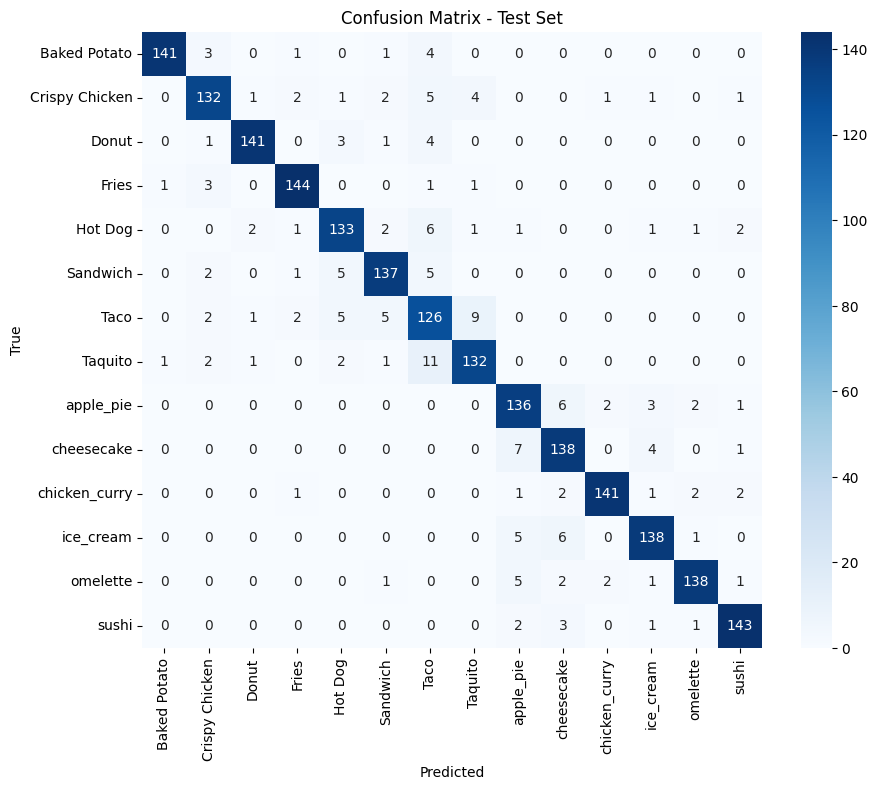

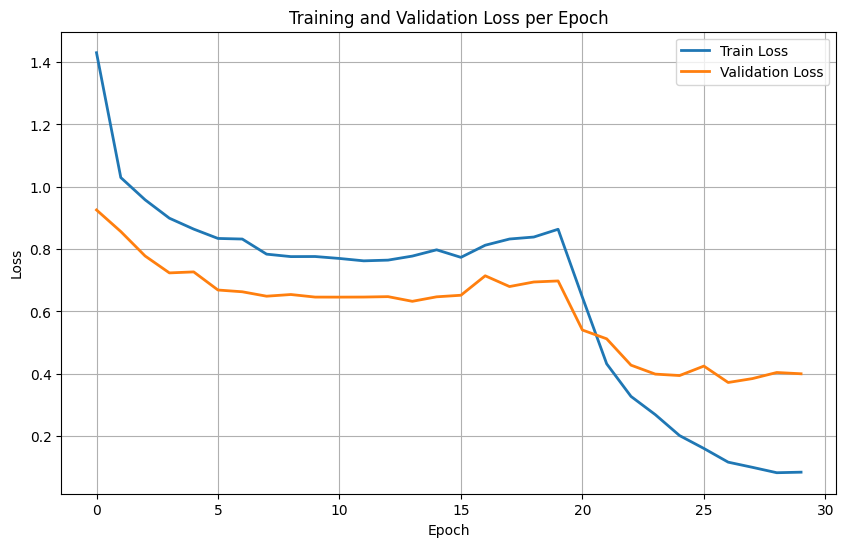

In [ ]:
# ======================================================
# 12) VALUTAZIONE COMPLETA SU TRAIN, VALIDATION E TEST
# ======================================================
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- Trova il miglior modello salvato automaticamente ---
best_model_files = list(Path(WORKDIR).glob("best_*.pth"))
if not best_model_files:
    raise FileNotFoundError("Nessun modello salvato trovato in WORKDIR.")

# Usa results_df per selezionare il modello con miglior Val Accuracy
best_model_name = results_df.sort_values(by="Best_Val_Accuracy", ascending=False).iloc[0]["Model"]

# Cerca file corrispondente (pref. full, altrimenti head)
best_model_file = None
for f in best_model_files:
    if best_model_name in f.name and "full" in f.name:
        best_model_file = f
        break
if best_model_file is None:
    # Se non esiste versione full, usa head
    for f in best_model_files:
        if best_model_name in f.name:
            best_model_file = f
            break

print(f"Carico il modello migliore: {best_model_file}")

# --- Ricrea il modello e carica i pesi ---
model = create_model(best_model_name, num_classes=num_classes).to(DEVICE)
model.load_state_dict(torch.load(best_model_file, map_location=DEVICE))
model.eval()

# --- Funzione di valutazione estesa ---
def evaluate_split(name, loader, model, criterion, device):
    loss, acc, preds, labels = eval_model(model, loader, criterion, device)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    print(f"\n[{name} SET]")
    print(f"Loss: {loss:.4f} | Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    return preds, labels, loss, acc, precision, recall, f1

# --- Calcola metriche sui tre split ---
train_preds, train_labels, train_loss, train_acc, train_prec, train_rec, train_f1 = evaluate_split('TRAIN', train_loader, model, criterion, DEVICE)
val_preds, val_labels, val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_split('VAL', val_loader, model, criterion, DEVICE)
test_preds, test_labels, test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate_split('TEST', test_loader, model, criterion, DEVICE)

# --- Riepilogo metriche ---
metrics_df = pd.DataFrame([
    ['Train', train_loss, train_acc, train_prec, train_rec, train_f1],
    ['Validation', val_loss, val_acc, val_prec, val_rec, val_f1],
    ['Test', test_loss, test_acc, test_prec, test_rec, test_f1]
], columns=['Split', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1'])

print("\nRiepilogo metriche globali:")
display(metrics_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1']))

# --- Report dettagliato per classi ---
print("\n=== Classification Report (Test Set) ===")
print(classification_report(test_labels, test_preds, target_names=unique_labels, zero_division=0))

# --- Confusion Matrix ---
plt.figure(figsize=(10,8))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

# ======================================================
# 13) CURVE DI APPRENDIMENTO
# ======================================================
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


# DISCUSSION

Il modello raggiunge un’accuratezza del 99% sul training set e circa 91% su validation e test, confermando un buon equilibrio tra apprendimento e generalizzazione. Alcune classi, come “Taco” e “apple_pie”, presentano F1-score leggermente inferiori, probabilmente a causa di somiglianze visive. Complessivamente, il modello mostra una performance robusta e bilanciata sulle categorie multi-classe.